# ***Sujet*** : **TUBERCULOSIS** **ANALYSIS** **USING** **TRANSFER** **LEARNING** **METHODS** 





# 1). What is Transfer Learning ?
                    
This deep learning technique enables developers to harness a neural network used for one task and apply it to another domain.

--->When to use it and for what benefits :


    

*   Existing model: it may exist that someone has already encountered the same problem as you. So there may already be a model for the task you are trying to handle.
*   Not enough data: you may also not have enough data to be able to train a model from A to Z
*   Not enough computing power: Not enough computing power**: training a tiny part of the layers of a 
neural network will be able to accelerate its learning






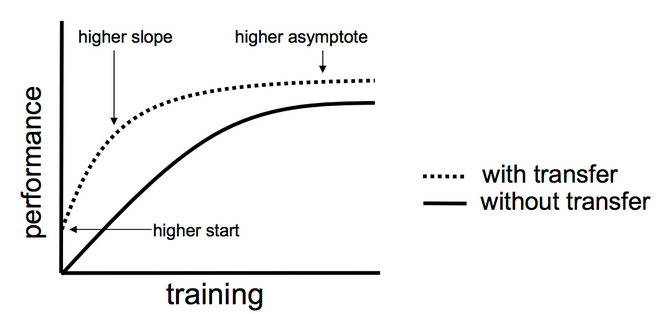

# 2) What is a pre-trained model?

A pre-trained model is a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve. Accordingly, due to the computational cost of training such models, it is common practice to import and use models from published literature (e.g. VGG, Inception, MobileNet).
   

* we will see after each model used with its archetecture*


**ImageNet**: is an image database organized according to the WordNet hierarchy, in which each node of the hierarchy is depicted by hundreds and thousands of images. 

The goal of this image classification challenge is to train a model that can correctly classify an input image into 1,000 separate object categories


**Image segmentation** is the process of partitioning an image into multiple segments. Image segmentation is typically used to locate objects and boundaries in images.








---



In [ ]:
# Importing the libraries
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import pickle as pkl
import tensorflow.keras as keras
from keras import backend as K
import cv2
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split   
tf.random.set_seed(1234)

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50
from tensorflow.keras.metrics import Recall, Precision

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
from tqdm import tqdm_notebook, tnrange
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42


In [ ]:
# the parameters we need to start the analysis
BATCH_SIZE = 100
IMG_WIDTH = 128 
IMG_HEIGHT = 128 
IMG_CHANNELS = 3
TRAIN_PATH = '/content/drive/My Drive/Train/'
TEST_PATH = '/content/drive/My Drive/test/'

 ## Importing Dataset from Google Drive

In [ ]:
# Importing drive method from colab for accessing google drive
from google.colab import drive 
# Mounting drive
# This will require authentication 
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
 os.chdir("/content/drive/My Drive")

# **I.  Loading and Pre-processing the data**


---


This part consists of resizing and loading the data we need so we can prepare it for the training.





In [ ]:
# Get and resize train images and masks
def get_train_data(path, train=True):
    ids = next(os.walk(path))[2]
   
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.float32)
    print('Getting and resizing train images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path  + id_, grayscale=False)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128,1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path  +'mask/'+ os.path.splitext(id_)[0]+'_mask'+'.png', grayscale=False))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255.0
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X_train, Y_train = get_train_data(TRAIN_PATH , train=True)
#to save it


In [ ]:
with open("train.pkl", "wb") as f:
    pkl.dump([X_train, Y_train], f)

In [ ]:
#to load it
with open("/content/drive/My Drive/train.pkl", "rb") as f:
    X_train, Y_train = pkl.load(f)
X_train
    

array([[[[0.0492272 ],
         [0.02306469],
         [0.02631257],
         ...,
         [0.05622653],
         [0.069732  ],
         [0.07262129]],

        [[0.0540808 ],
         [0.02418701],
         [0.02636204],
         ...,
         [0.05398468],
         [0.06696221],
         [0.07179514]],

        [[0.05133043],
         [0.02313898],
         [0.02308686],
         ...,
         [0.04623539],
         [0.05722574],
         [0.06367157]],

        ...,

        [[0.00580512],
         [0.00472834],
         [0.00428676],
         ...,
         [0.02481772],
         [0.030382  ],
         [0.04782972]],

        [[0.02897353],
         [0.02960754],
         [0.02928763],
         ...,
         [0.09693356],
         [0.10482067],
         [0.1019292 ]],

        [[0.00298226],
         [0.00357669],
         [0.00377554],
         ...,
         [0.1592116 ],
         [0.16405104],
         [0.14425214]]],


       [[[0.09399997],
         [0.07447487],
         [0.06

In [ ]:
# Get and resize test images and masks
def get_test_data(path, train=True):
    ids = next(os.walk(path))[2]
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    print('Getting and resizing test images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path  + id_, grayscale=False)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path  +'mask/'+ os.path.splitext(id_)[0]+'_mask'+'.png', grayscale=False))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X_test, Y_test = get_test_data(TEST_PATH , train=True)

#to save it
with open("test.pkl", "wb") as f:
    pkl.dump([X_test, Y_test], f)


In [ ]:
#to load it
with open("/content/drive/My Drive/test.pkl", "rb") as f:
    X_test, Y_test = pkl.load(f)
X_test 



array([[[[0.15846634],
         [0.13891412],
         [0.1331314 ],
         ...,
         [0.21787952],
         [0.23655161],
         [0.21824494]],

        [[0.17494221],
         [0.14684716],
         [0.13827938],
         ...,
         [0.23932903],
         [0.25868237],
         [0.24137264]],

        [[0.1644627 ],
         [0.13464609],
         [0.12300818],
         ...,
         [0.22976676],
         [0.24645261],
         [0.2335032 ]],

        ...,

        [[0.1327242 ],
         [0.14914854],
         [0.14639679],
         ...,
         [0.15083347],
         [0.1720995 ],
         [0.21457896]],

        [[0.09166574],
         [0.11145653],
         [0.10985265],
         ...,
         [0.25371212],
         [0.27302676],
         [0.2699965 ]],

        [[0.00269352],
         [0.00367553],
         [0.00370288],
         ...,
         [0.29711366],
         [0.30974945],
         [0.27745768]]],


       [[[0.09405424],
         [0.08653174],
         [0.07

# **II. image Augmentation**


---


data augmentation is a way to multiply your training data. This is especially important if not much data is available.

In [ ]:
from keras.preprocessing.image import *
                    #----------Create training Generators-----------
# Image and mask generator
tf.keras.preprocessing.image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')


# fitting mask and image 
tf.keras.preprocessing.image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=tf.keras.preprocessing.image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)


In [ ]:
len(X_train[:int(X_train.shape[0]*0.9):])

382

In [ ]:
                              #----------Create validation Generators-----------
image = tf.keras.preprocessing.image
# Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()


# fitting mask and image 
image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

In [ ]:
len(X_train[int(X_train.shape[0]*0.9):])

43

In [ ]:
# the training and validation generators
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

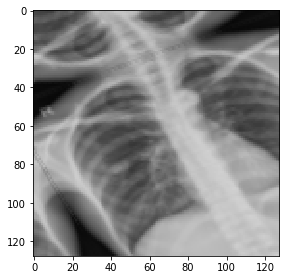

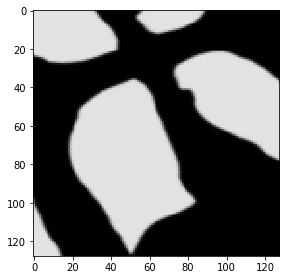

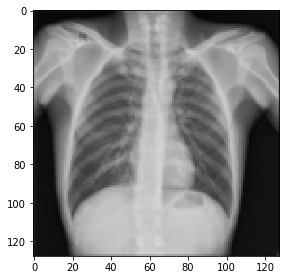

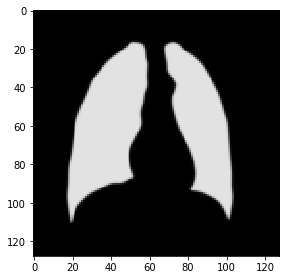

In [ ]:
# examining  the shape of the images

imshow(x.next()[3].squeeze())
plt.show()
imshow(np.squeeze(y.next()[3].squeeze()))
plt.show()
imshow(x_val.next()[3].squeeze())
plt.show()
imshow(np.squeeze(y_val.next()[3].squeeze()))
plt.show()

#  **III.  the U-net model**


---


After preparing the data and creating both train validation generators, we move now to the next step (building the model).
we chose to work with The **U-Net**  a deep learning model which is convolutional network architecture for fast and precise segmentation of images, **U-Net** can be trained end-to-end with fewer training samples.


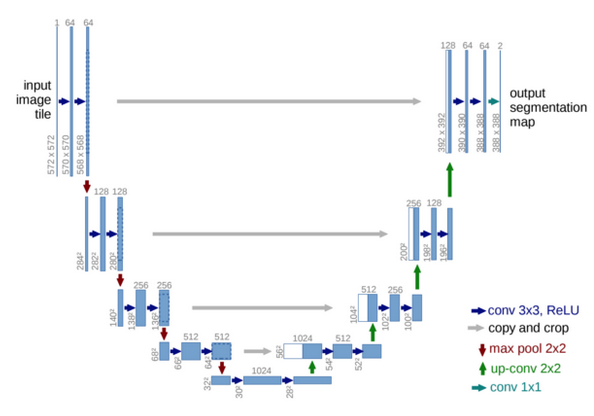

The Structure looks like a typical Encoder-Decoder model, with an added fact that convolution tensor layers of similar sizes are concatenated with each other.





**Metrics**:
 A metric is a function that is used to judge the performance of your model.

In [ ]:
# Dice coefficient metric
def dice_coef(y_true, y_pred):
 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [ ]:
# jaccard_distance metric
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

In [ ]:
# plot training and validation data of model
def plot_model_history(history):
    
    print(history.history.keys())
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
   # summarize history for jaccard_distance
    plt.plot(history.history['jaccard_distance'])
    plt.plot(history.history['val_jaccard_distance'])
    plt.title('model jaccard_distance ')
    plt.ylabel('jaccard_distance')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for dice_coef
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice_coef ')
    plt.ylabel('dice_coef')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
 

**MobileNetV2**

The MobileNetV2 architecture is based on an inverted residual structure where the input and output of the residual block are thin bottleneck layers opposite to traditional residual models which use expanded representations in the input an MobileNetV2 uses lightweight depthwise convolutions to filter features in the intermediate expansion layer. 

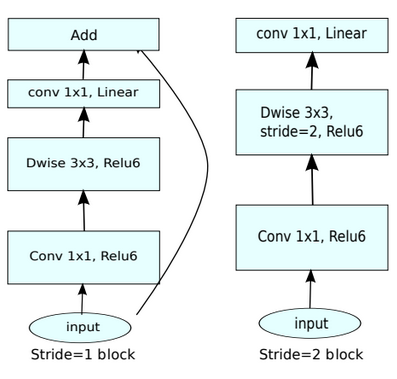

In [ ]:
    img_input = Input(shape=(128, 128,1), name="input_image")
    img_conc = Concatenate()([img_input, img_input, img_input])  
    encoder = MobileNetV2(input_tensor=img_conc,input_shape=(128,128,3), weights="imagenet", include_top=False)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    encoder.trainable = False
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(img_input, x)  
    model.summary()




9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 128, 3)  0           input_image[0][0]                
                                                                 input_image[0][0]                
                                                                 input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         concatenate[0][0]                
_______________________________

**optimizer**: is one of the two arguments required for compiling a Keras model
Usage with **compile**() & **fit**()

    * SGD
    * RMSprop
    * Adam
    * Adadelta
    * Adagrad
    * Adamax
    * Nadam
    * Ftrl




In [ ]:

model.compile(optimizer= tf.keras.optimizers.RMSprop(), loss='binary_crossentropy', metrics=[dice_coef, jaccard_distance,  'accuracy'])


# **IV. Training**


---



In [ ]:
checkpoint = ModelCheckpoint('best-model.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
# Fitting the model RMSprop()
results = model.fit(train_generator, validation_data=val_generator, validation_steps=10, 
                              epochs=20, steps_per_epoch=220, callbacks=callbacks_list)

Epoch 1/20
220/220 [==============================] - 68s 265ms/step - loss: 0.3544 - dice_coef: 0.5990 - jaccard_distance: 56.5530 - accuracy: 0.6248 - val_loss: 0.1703 - val_dice_coef: 0.7508 - val_jaccard_distance: 39.3851 - val_accuracy: 0.6624

Epoch 00001: val_loss improved from inf to 0.17026, saving model to best-model.h5
Epoch 2/20
220/220 [==============================] - 56s 256ms/step - loss: 0.1583 - dice_coef: 0.7920 - jaccard_distance: 34.0844 - accuracy: 0.6507 - val_loss: 0.1350 - val_dice_coef: 0.8229 - val_jaccard_distance: 29.5168 - val_accuracy: 0.6618

Epoch 00002: val_loss improved from 0.17026 to 0.13503, saving model to best-model.h5
Epoch 3/20
220/220 [==============================] - 56s 255ms/step - loss: 0.1736 - dice_coef: 0.8005 - jaccard_distance: 32.1539 - accuracy: 0.6476 - val_loss: 0.1344 - val_dice_coef: 0.8313 - val_jaccard_distance: 28.3303 - val_accuracy: 0.6616

Epoch 00003: val_loss improved from 0.13503 to 0.13442, saving model to best-model

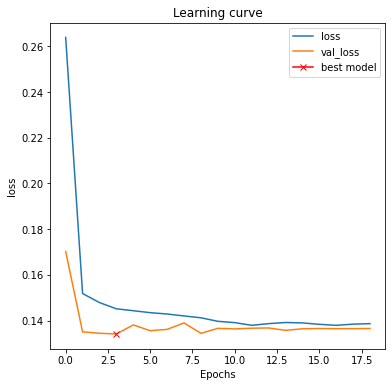

In [ ]:
plt.figure(figsize=(6, 6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

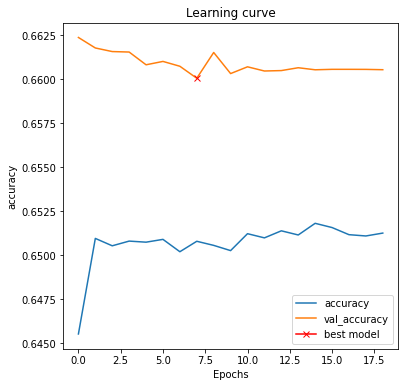

In [ ]:
plt.figure(figsize=(6, 6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(results.history["val_accuracy"]), np.min(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();

dict_keys(['loss', 'dice_coef', 'jaccard_distance', 'accuracy', 'val_loss', 'val_dice_coef', 'val_jaccard_distance', 'val_accuracy', 'lr'])


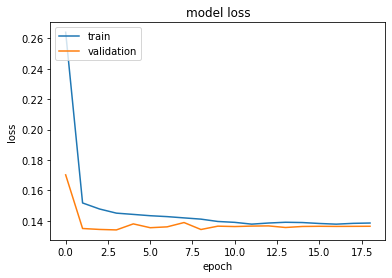

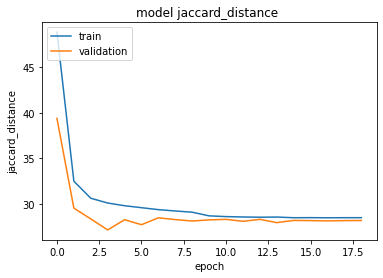

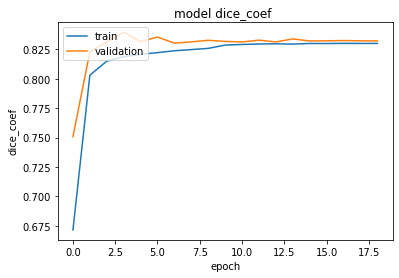

In [ ]:
# checking the metrics
plot_model_history(results)

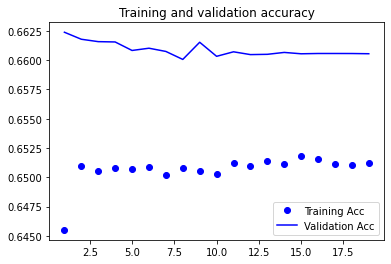

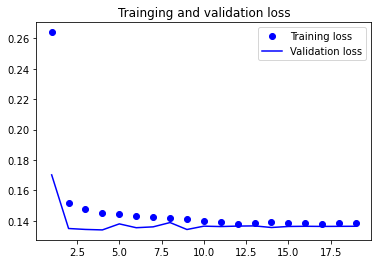

In [ ]:
accuracy = results.history['accuracy']
val_accuracy = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training Acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation Acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Trainging and validation loss')
plt.legend()
plt.show()

#**Ufreezing U-NET**

When training a model while transfer layer, we freeze training of certain layers due to multiple reasons, such as they might have already converged or we want to train the newly added layers to an already pre-trained models. This is a really basic concept of Transfer learning.
  How do I freeze and unfreeze layers?
- In keras if you want to freeze layers use: layer.trainable = False
And to unfreeze: layer.trainable = True


---



#  **V. Loading the pre-trained model-Prediction**



**MobileNet**

In [ ]:
model.load_weights('best-model.h5')

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(x_val, verbose=1)
preds_test = model.predict(X_test, verbose=1)


# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


5/5 [==============================] - 0s 46ms/step


In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[2].set_title('predected mask')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='w', levels=[0.5])
    ax[3].set_title(' Predicted binary mask');
    


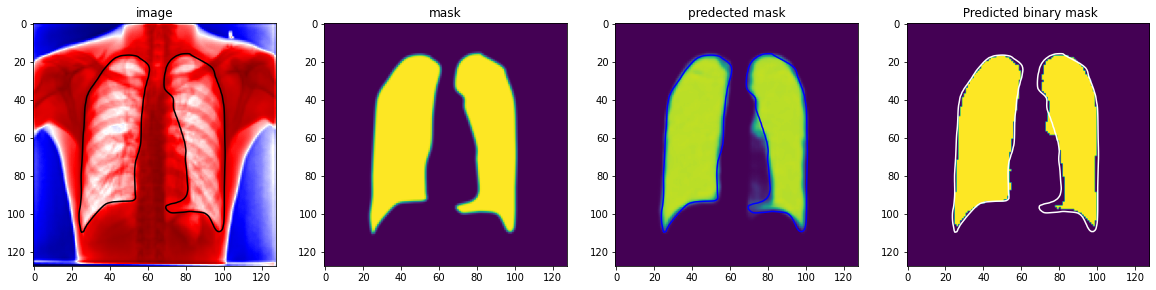

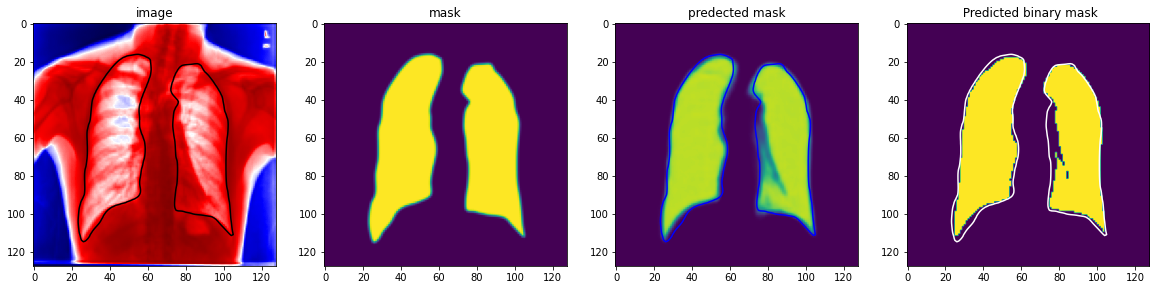

In [ ]:
plot_sample(X_train, Y_train, preds_train, preds_train_t, ix=14)
plot_sample(X_train, Y_train, preds_train, preds_train_t, ix=20)

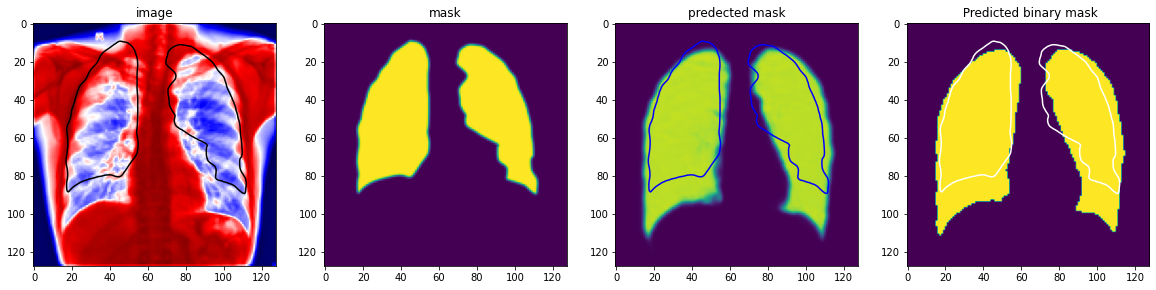

In [ ]:
plot_sample(x_val.next(), y_val.next(), preds_val, preds_val_t, ix= 2)

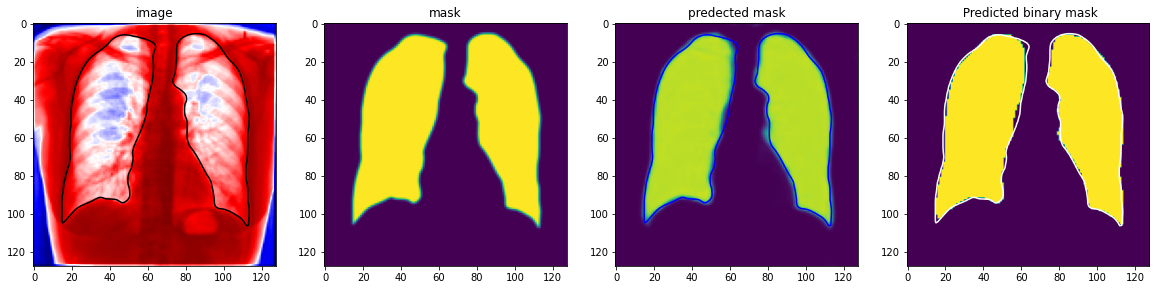

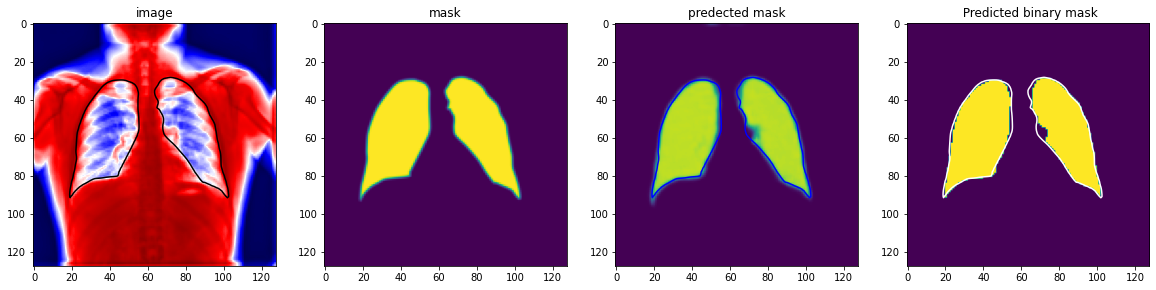

In [ ]:
plot_sample(X_test, Y_test, preds_test, preds_test_t, ix=10)
plot_sample(X_test, Y_test, preds_test, preds_test_t, ix=15)

# **VGG-16**

VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It was one of the famous model submitted to ILSVRC-2014.



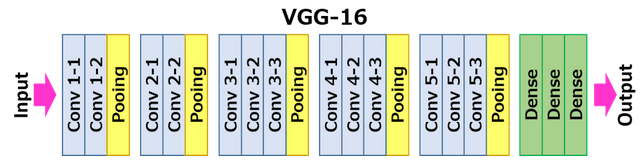



---



In [ ]:
img_input = Input(shape=(128, 128,1), name="input_image")
img_conc = Concatenate()([img_input, img_input, img_input])  
encoder = VGG16(input_tensor=img_conc, weights="imagenet", include_top=False)
skip_connection_names = [ "block1_conv2", "block2_conv2", "block3_conv3","block4_conv3"]
encoder_output = encoder.get_layer("block5_conv3").output
encoder.trainable = False        
f = [8,16,32, 48]
x = encoder_output
for i in range(1, len(skip_connection_names)+1, 1):
    x_skip = encoder.get_layer(skip_connection_names[-i]).output
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, x_skip])
        
    x = Conv2D(f[-i], (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
        
    x = Conv2D(f[-i], (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
        
x = Conv2D(1, (1, 1), padding="same")(x)
x = Activation("sigmoid")(x)
  
model = Model(img_input, x)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
concatenate_26 (Concatenate)    (None, 128, 128, 3)  0           input_image[0][0]                
                                                                 input_image[0][0]                
                                                                 input_image[0][0]                
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        concatenate_26[0][0]             
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer= tf.keras.optimizers.RMSprop(), loss='binary_crossentropy', metrics=[dice_coef, jaccard_distance,  'accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint('VGG16-model.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
# Fitting the model
results3 = model.fit(train_generator, validation_data=val_generator, validation_steps=10, 
                              epochs=20, steps_per_epoch=220, callbacks=callbacks_list)

Epoch 1/20
220/220 [==============================] - 87s 342ms/step - loss: 0.4902 - dice_coef: 0.5323 - jaccard_distance: 63.2905 - accuracy: 0.5628 - val_loss: 0.2449 - val_dice_coef: 0.6200 - val_jaccard_distance: 54.3834 - val_accuracy: 0.6625

Epoch 00001: val_loss improved from inf to 0.24491, saving model to VGG16-model.h5
Epoch 2/20
220/220 [==============================] - 72s 325ms/step - loss: 0.2597 - dice_coef: 0.6634 - jaccard_distance: 50.2213 - accuracy: 0.6495 - val_loss: 0.1685 - val_dice_coef: 0.7905 - val_jaccard_distance: 34.2735 - val_accuracy: 0.6617

Epoch 00002: val_loss improved from 0.24491 to 0.16851, saving model to VGG16-model.h5
Epoch 3/20
220/220 [==============================] - 72s 328ms/step - loss: 0.1790 - dice_coef: 0.7601 - jaccard_distance: 38.4112 - accuracy: 0.6503 - val_loss: 0.1431 - val_dice_coef: 0.8110 - val_jaccard_distance: 31.2581 - val_accuracy: 0.6621

Epoch 00003: val_loss improved from 0.16851 to 0.14312, saving model to VGG16-mo

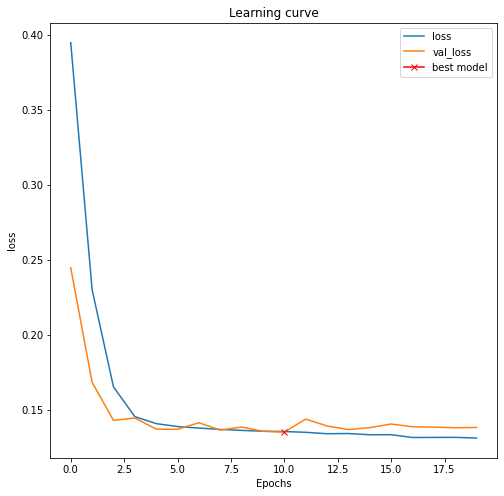

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results3.history["loss"], label="loss")
plt.plot(results3.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results3.history["val_loss"]), np.min(results3.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

dict_keys(['loss', 'dice_coef', 'jaccard_distance', 'accuracy', 'val_loss', 'val_dice_coef', 'val_jaccard_distance', 'val_accuracy', 'lr'])


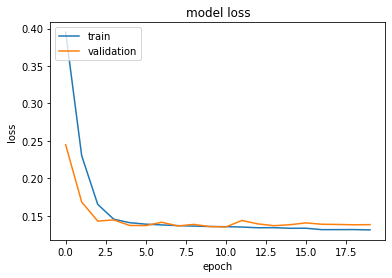

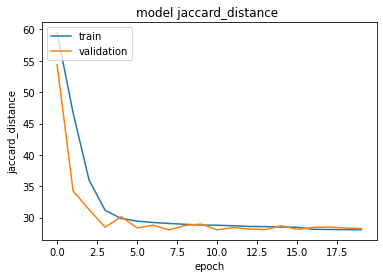

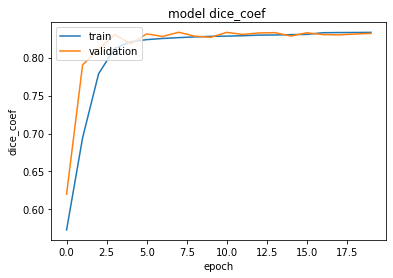

In [ ]:
# checking the metrics
plot_model_history(results3)

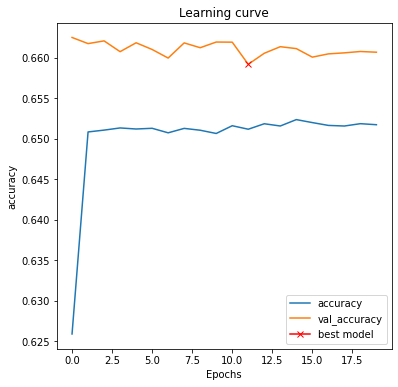

In [ ]:
plt.figure(figsize=(6, 6))
plt.title("Learning curve")
plt.plot(results3.history["accuracy"], label="accuracy")
plt.plot(results3.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(results3.history["val_accuracy"]), np.min(results3.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();

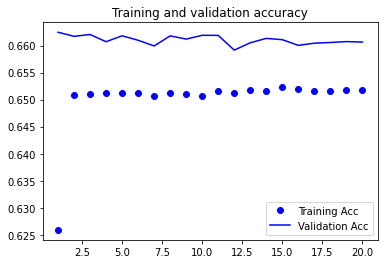

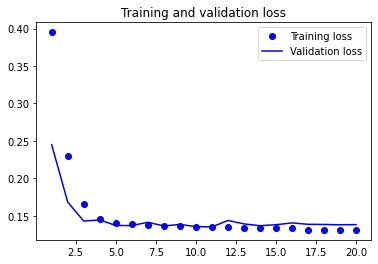

In [ ]:
accuracy = results3.history['accuracy']
val_accuracy = results3.history['val_accuracy']
loss = results3.history['loss']
val_loss = results3.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training Acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation Acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

***VGG16 Prediction***

In [ ]:
model.load_weights('VGG16-model.h5')

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(x_val, verbose=1)
preds_test = model.predict(X_test, verbose=1)


# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


5/5 [==============================] - 1s 158ms/step


In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[2].set_title('predected mask')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='w', levels=[0.5])
    ax[3].set_title(' Predicted binary mask');
    

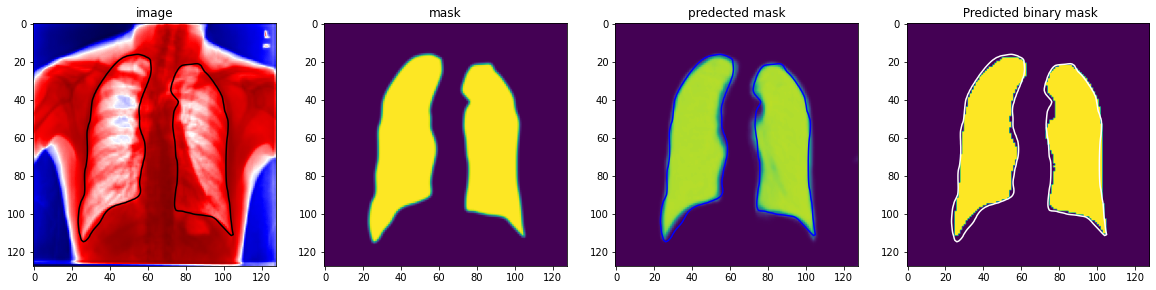

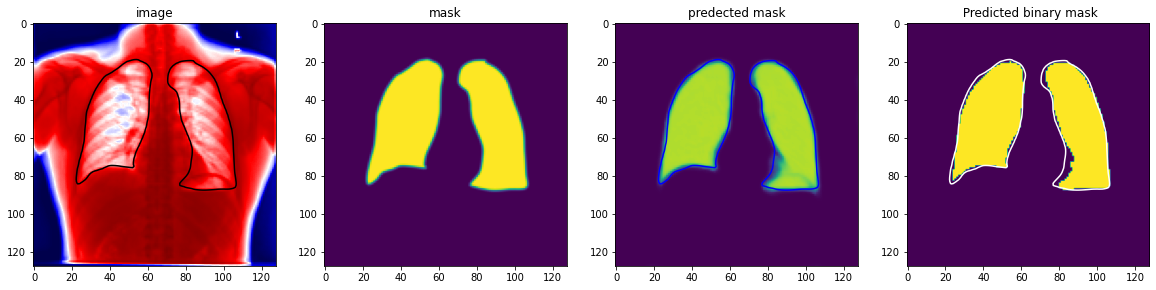

In [ ]:
plot_sample(X_train, Y_train, preds_train, preds_train_t, ix=20)
plot_sample(X_train, Y_train, preds_train, preds_train_t, ix=12)

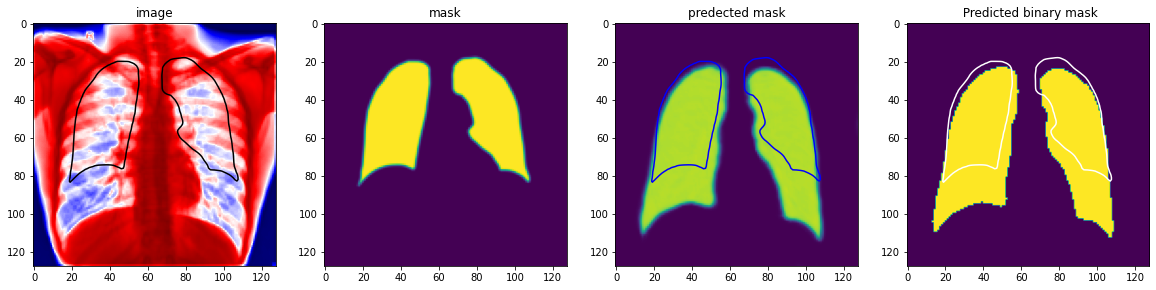

In [ ]:
plot_sample(x_val.next(), y_val.next(), preds_val, preds_val_t, ix= 5)

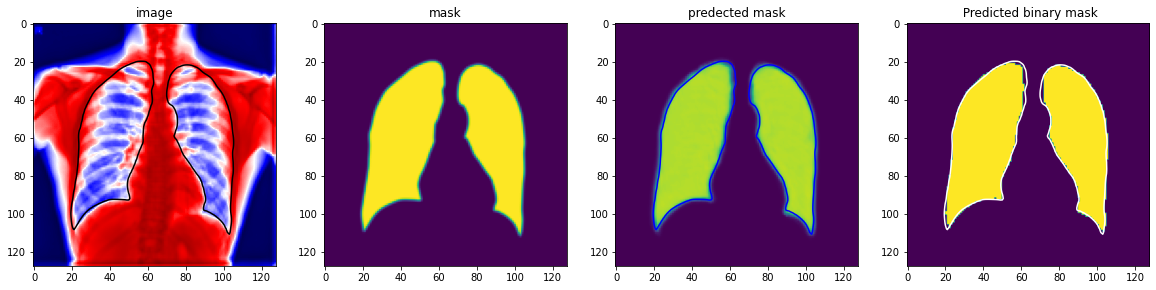

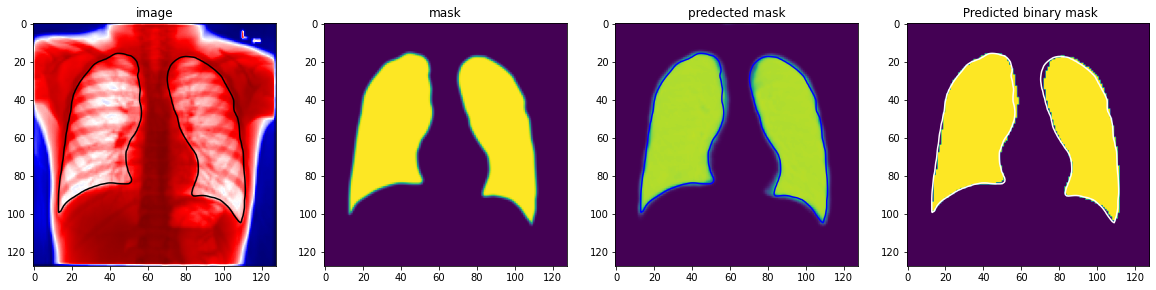

In [ ]:
plot_sample(X_test, Y_test, preds_test, preds_test_t, ix=11)
plot_sample(X_test, Y_test, preds_test, preds_test_t, ix=9)

# **Ufreezing** **VGG16**


---



In [ ]:
encoder.trainable = True
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
concatenate_26 (Concatenate)    (None, 128, 128, 3)  0           input_image[0][0]                
                                                                 input_image[0][0]                
                                                                 input_image[0][0]                
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        concatenate_26[0][0]             
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer= tf.keras.optimizers.RMSprop(), loss='binary_crossentropy', metrics=[dice_coef, jaccard_distance,  'accuracy'])


In [ ]:
checkpoint = ModelCheckpoint('ufreezing-VGG-model.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
# Fitting the model
results4 = model.fit(train_generator, validation_data=val_generator, validation_steps=10, 
                              epochs=10, steps_per_epoch=220, callbacks=callbacks_list)

Epoch 1/10
220/220 [==============================] - 130s 572ms/step - loss: 0.2967 - dice_coef: 0.7062 - jaccard_distance: 43.7529 - accuracy: 0.6353 - val_loss: 0.3244 - val_dice_coef: 0.6649 - val_jaccard_distance: 49.6223 - val_accuracy: 0.5898

Epoch 00001: val_loss improved from inf to 0.32442, saving model to ufreezing-VGG-model.h5
Epoch 2/10
220/220 [==============================] - 127s 578ms/step - loss: 0.1518 - dice_coef: 0.8080 - jaccard_distance: 31.6737 - accuracy: 0.6506 - val_loss: 0.1463 - val_dice_coef: 0.8199 - val_jaccard_distance: 29.9361 - val_accuracy: 0.6581

Epoch 00002: val_loss improved from 0.32442 to 0.14625, saving model to ufreezing-VGG-model.h5
Epoch 3/10
220/220 [==============================] - 129s 585ms/step - loss: 0.1453 - dice_coef: 0.8158 - jaccard_distance: 30.5740 - accuracy: 0.6507 - val_loss: 0.1363 - val_dice_coef: 0.8307 - val_jaccard_distance: 28.4065 - val_accuracy: 0.6615

Epoch 00003: val_loss improved from 0.14625 to 0.13628, savin

dict_keys(['loss', 'dice_coef', 'jaccard_distance', 'accuracy', 'val_loss', 'val_dice_coef', 'val_jaccard_distance', 'val_accuracy', 'lr'])


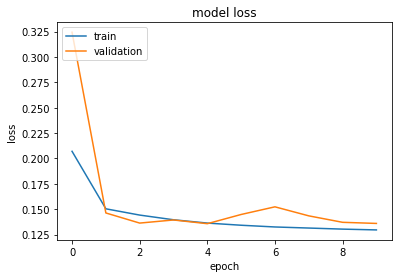

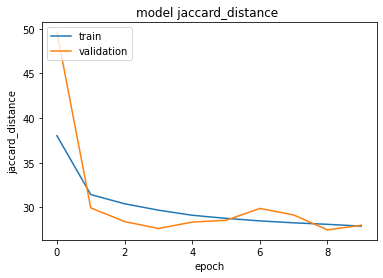

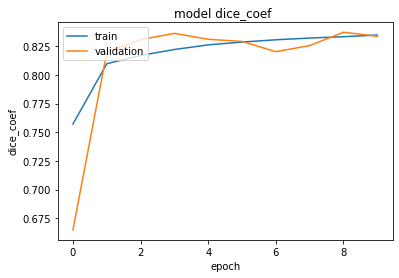

In [ ]:
# checking the metrics
plot_model_history(results4)

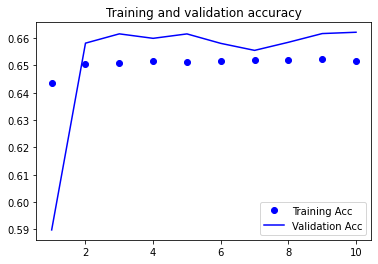

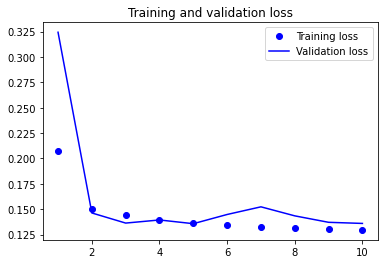

In [ ]:
accuracy = results4.history['accuracy']
val_accuracy = results4.history['val_accuracy']
loss = results4.history['loss']
val_loss = results4.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training Acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation Acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# **ResNet50**

 ResNet50 is a variant of ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. It has 3.8 x 10^9 Floating points operations. 

 Architecture of ResNet50 is shown and includes convolution layers, max pooling layers, and a fully connected layer. c A ResNet50 model was pretrained on a million images from the ImageNet database and can classify images into 1000 object categories. 

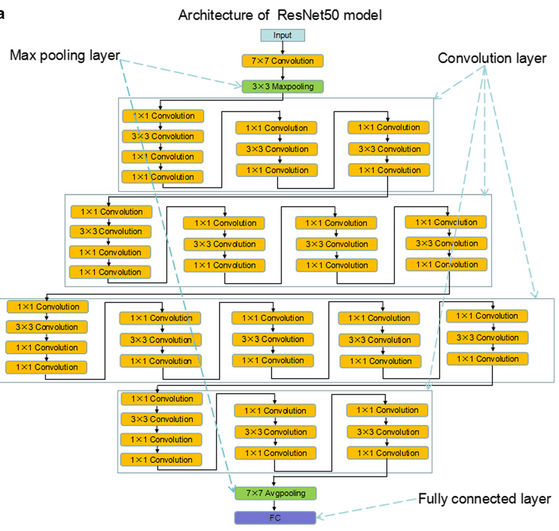

In [ ]:
    img_input = Input(shape=(128, 128,1), name="input_image")
    img_conc = Concatenate()([img_input, img_input, img_input])  
    encoder = ResNet50(input_tensor=img_conc,input_shape=(128,128,3), weights="imagenet", include_top=False)
    skip_connection_names = ["input_image", "conv1_relu", "conv2_block3_out", "conv3_block4_out"]
    encoder_output = encoder.get_layer("conv4_block6_out").output
    encoder.trainable = False
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(img_input, x)  
    model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
concatenate_31 (Concatenate)    (None, 128, 128, 3)  0           input_image[0][0]                
                                                                 input_image[0][0]                
                                                                 input_image[0][0]                
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           concatenate_31[0][0]             
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef, 'accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


checkpoint = ModelCheckpoint('ResNet-model.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
import tensorflow.keras as keras
# Fitting the model
results5 = model.fit(train_generator, validation_data=val_generator, validation_steps=10, 
                              epochs=10, steps_per_epoch=220, callbacks=callbacks_list)


Epoch 1/10
220/220 [==============================] - 72s 316ms/step - loss: 0.5766 - dice_coef: 0.3948 - accuracy: 0.5102 - val_loss: 0.5571 - val_dice_coef: 0.4042 - val_accuracy: 0.5720

Epoch 00001: val_loss improved from inf to 0.55710, saving model to ResNet-model.h5
Epoch 2/10
220/220 [==============================] - 68s 312ms/step - loss: 0.3741 - dice_coef: 0.5467 - accuracy: 0.6402 - val_loss: 0.7610 - val_dice_coef: 0.4893 - val_accuracy: 0.3305

Epoch 00002: val_loss did not improve from 0.55710
Epoch 3/10
220/220 [==============================] - 69s 312ms/step - loss: 0.3322 - dice_coef: 0.5804 - accuracy: 0.6433 - val_loss: 0.7903 - val_dice_coef: 0.5062 - val_accuracy: 0.3560

Epoch 00003: val_loss did not improve from 0.55710
Epoch 4/10
220/220 [==============================] - 69s 313ms/step - loss: 0.3058 - dice_coef: 0.6070 - accuracy: 0.6424 - val_loss: 0.2649 - val_dice_coef: 0.6480 - val_accuracy: 0.6570

Epoch 00004: val_loss improved from 0.55710 to 0.26493

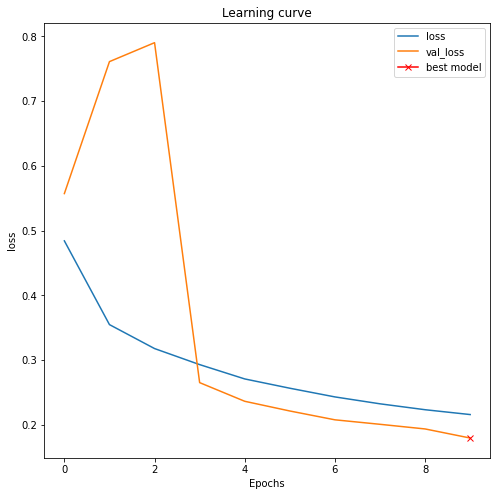

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results5.history["loss"], label="loss")
plt.plot(results5.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results5.history["val_loss"]), np.min(results5.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()

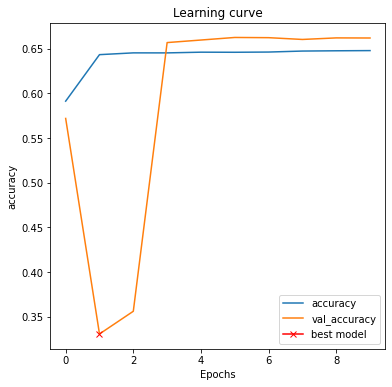

In [ ]:
plt.figure(figsize=(6, 6))
plt.title("Learning curve")
plt.plot(results5.history["accuracy"], label="accuracy")
plt.plot(results5.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(results5.history["val_accuracy"]), np.min(results5.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();

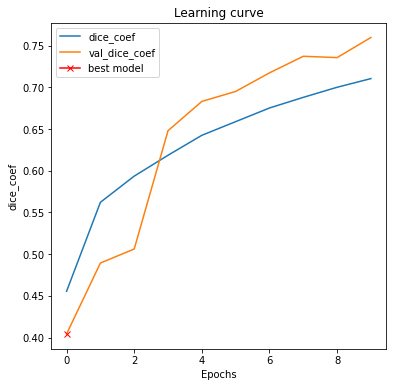

In [ ]:
plt.figure(figsize=(6, 6))
plt.title("Learning curve")
plt.plot(results5.history["dice_coef"], label="dice_coef")
plt.plot(results5.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmin(results5.history["val_dice_coef"]), np.min(results5.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();

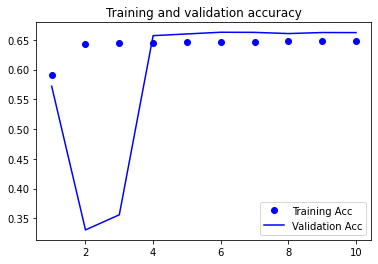

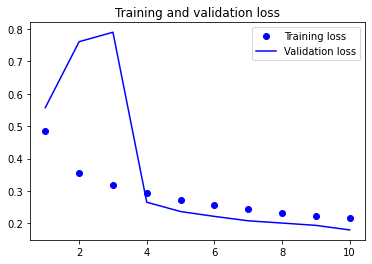

In [ ]:
accuracy = results5.history['accuracy']
val_accuracy = results5.history['val_accuracy']
loss = results5.history['loss']
val_loss = results5.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training Acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation Acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

***ResNet50 Prediction***

In [ ]:
model.load_weights('ResNet-model.h5')

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(x_val, verbose=1)
preds_test = model.predict(X_test, verbose=1)


# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

5/5 [==============================] - 0s 90ms/step


In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[2].set_title('predected mask')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='w', levels=[0.5])
    ax[3].set_title(' Predicted binary mask');
    

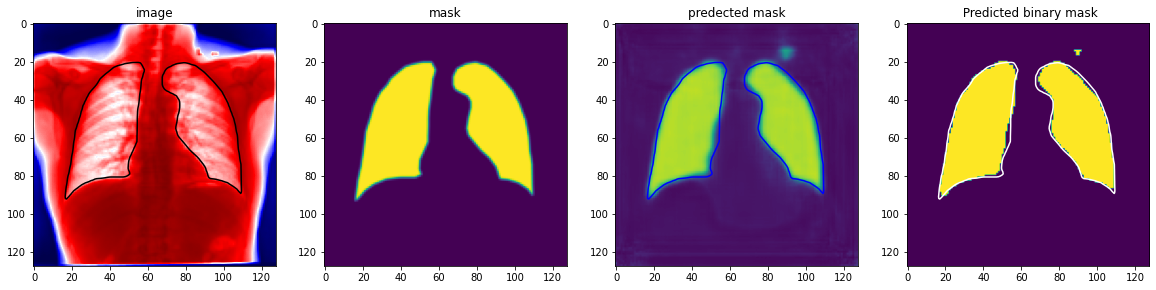

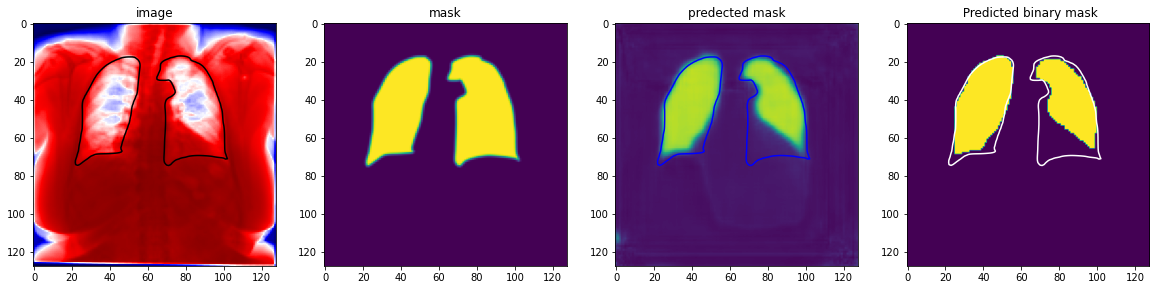

In [ ]:
plot_sample(X_train, Y_train, preds_train, preds_train_t, ix=45)
plot_sample(X_train, Y_train, preds_train, preds_train_t, ix=33)

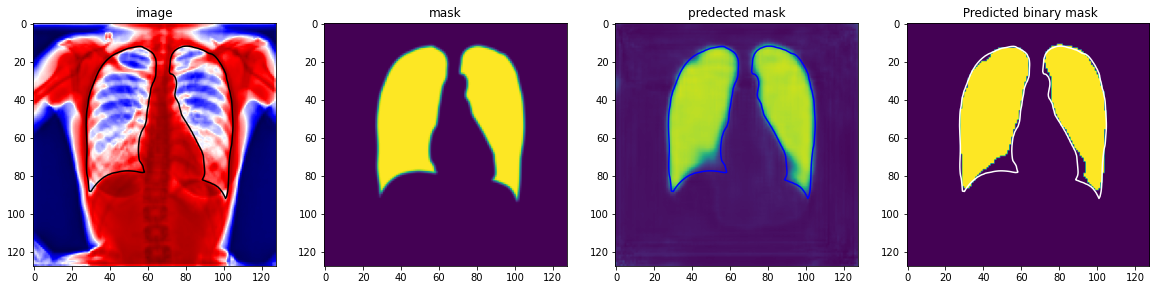

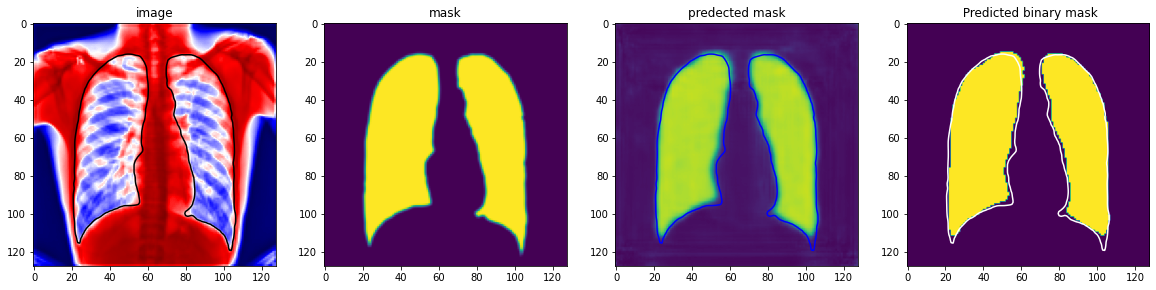

In [ ]:
plot_sample(X_test, Y_test, preds_test, preds_test_t, ix=2)
plot_sample(X_test, Y_test, preds_test, preds_test_t, ix=77)